In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [2]:
import sys
sys.path.append("../libs/")

In [3]:
from keplergl import KeplerGl
import json
from tqdm.notebook import tqdm
import numpy as np
import torch
import torch.nn as nn
from train_utils import FeatureQuantization
from math_utils import do_kmeans, assign_to_nearest_anchor
from visualize import StackedFeatureGrapher

# Clustering embeddings

The clustering of area embedding vectors involves grouping similar geographic areas based on their usage patterns. The number of clusters can be adjusted according to specific analytical needs. 

In [5]:
data_name = "2021"
state_dict = torch.load("../data/japan_city/model/"+data_name+".pth")
with open("../data/japan_city/geojson/"+data_name+".geojson", "r") as f:
    mesh_data = json.load(f)
embeddings = torch.tensor([mesh["properties"]["vector"] for mesh in mesh_data["features"]])

In [6]:
# K-means clustering
cluster_num = 8
result, element_num_in_cluster = do_kmeans(cluster_num, embeddings, with_center = False, seed = 20210401)

## Visualize approximated area usage pattens each cluster.

By applying the model's decoder weights to the embeddings, we can approximate the distribution of area features. The approximated feature distributions are visualized using stacked bar graphs, allowing for the analysis of usage trends in each cluster.

In [7]:
quantization = FeatureQuantization()
_, decoder = state_dict["embedding.weight"], state_dict["decode_linear.weight"]
softmax = nn.Softmax(dim = 1)
stay_weight_matrix = np.load("../data/util_file/stay_weight_matrix.npy")

approximation_stats = softmax(torch.matmul(embeddings, decoder.T))
stay_each_mesh_dow_dt_e =approximation_stats.numpy().dot(stay_weight_matrix).reshape(embeddings.shape[0], 2, 12, 7)
stay_each_mesh_dow_e_dt =np.transpose(stay_each_mesh_dow_dt_e, (0, 1, 3, 2))

/Users/tamuranaoki/Documents/workspace/my_paper/anchoring/code/0503/openuas/src/../libs/visualize.py:141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


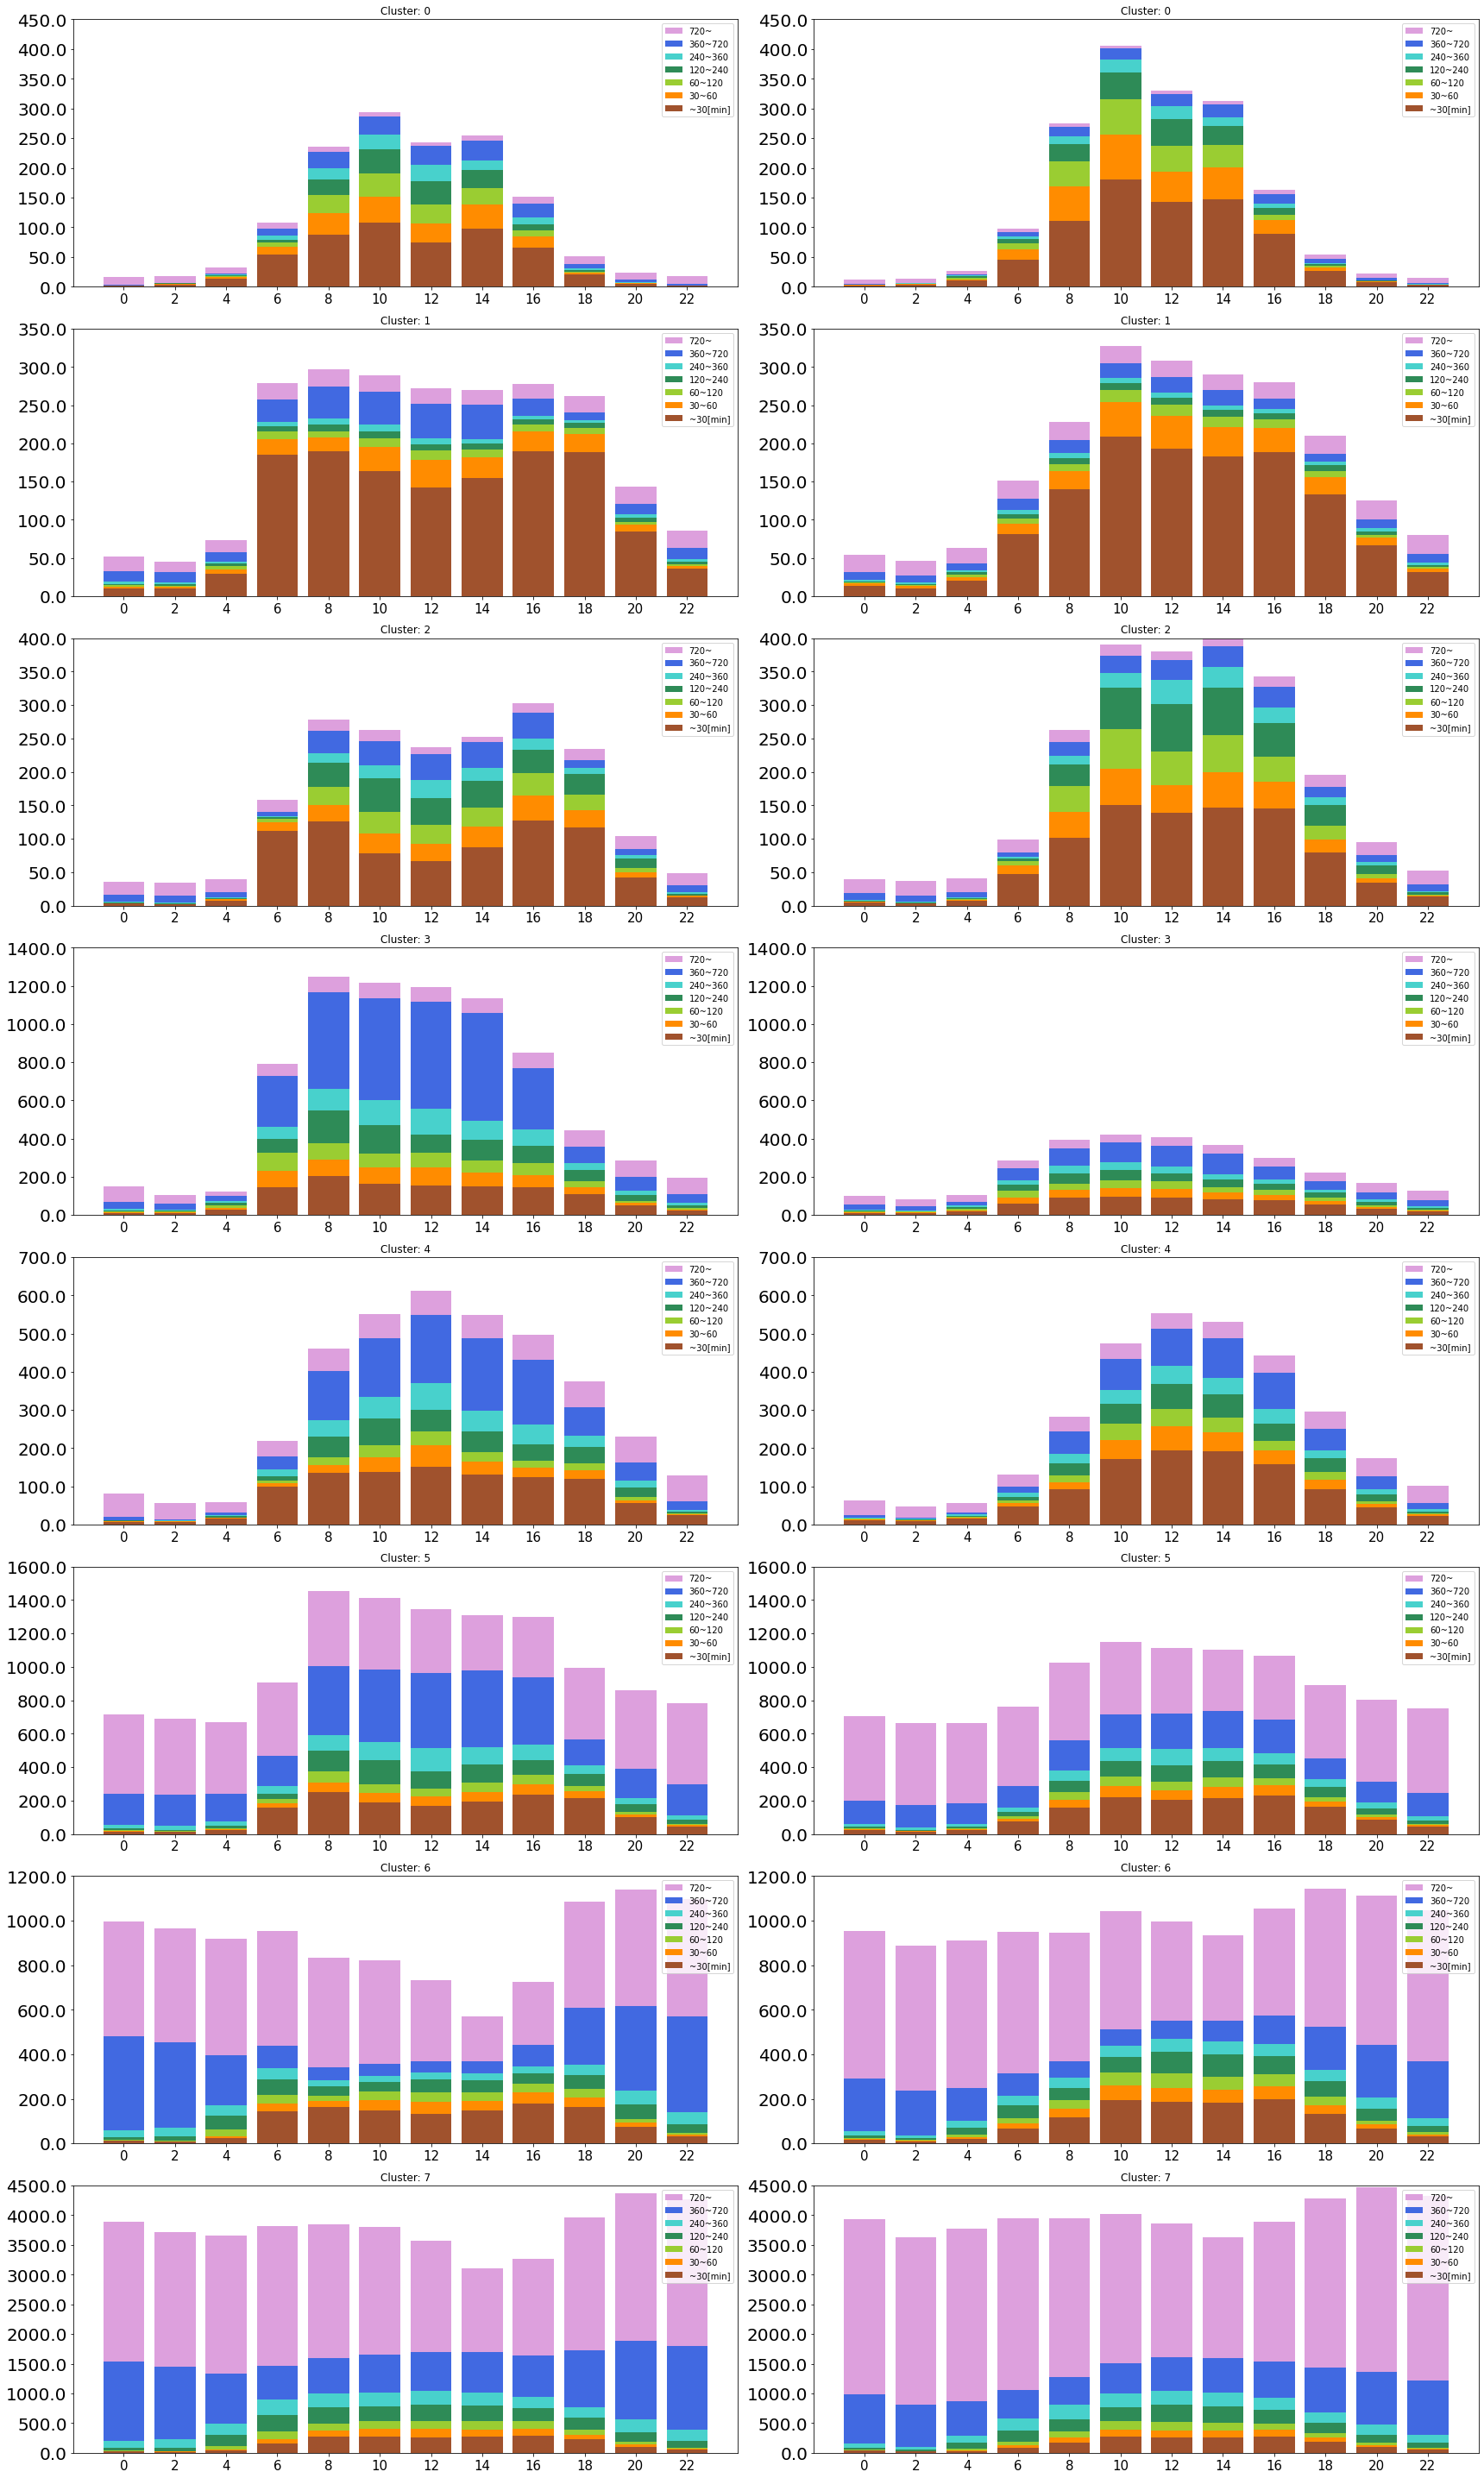

In [8]:
# Stacked graph(stay usage patterns)
visualizer = StackedFeatureGrapher(FeatureQuantization(), day_counts = [22,8])
sorted_indices = visualizer.aggregate_data_from_approximated_features(stay_each_mesh_dow_e_dt, result, sort=True)#sort clusters
result = [-1 if cls == -1 else sorted_indices.index(cls) for cls in result]
visualizer.visualize(visualizer.elapsed_each_time_each_cluster, title="Elapsed")

## Geographial visualization of each cluster.

Add cluster labels to the properties of a GeoJSON, and visualize them with kepler.gl. In kepler.gl, you can color-code by cluster label and use the filter function to focus on specific clusters.


In [10]:
from visualize import mesh_data_to_geojson
for i in range(len(mesh_data["features"])):
    mesh_data["features"][i]["properties"]["cluster"] = result[i]

In [13]:
m = KeplerGl(height=800, width=1200, data={"cluster_map": mesh_data})
# m.config = config
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'cluster_map': {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'typ…